<a href="https://colab.research.google.com/github/Mfys212/GNN-for-Molekul-Classifier/blob/main/GNN_Molekul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 17.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as DL_geo
from torch_geometric.nn import GCNConv, global_mean_pool, GINEConv
from torch.utils.data import DataLoader, TensorDataset
from rdkit import Chem
from rdkit.Chem import rdmolops, AllChem, Draw
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import random
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import concurrent.futures
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_2class_prep = pd.read_csv('https://raw.githubusercontent.com/Mfys212/dokumen/refs/heads/main/01_label2class_sars.csv')
df_2class_prep

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL541133,active,Cc1ccc([N+](=O)[O-])cc1S(=O)(=O)c1nc(-c2cnc3cc...,434.886,4.16062,0.0,8.0,7.000000
1,CHEMBL538346,active,Oc1cccc(-c2nc(N3CCOCC3)c3oc4ncccc4c3n2)c1,348.362,2.98020,1.0,7.0,8.000000
2,CHEMBL541643,active,Oc1cccc(-c2nc(N3CCOCC3)c3sccc3n2)c1,313.382,2.90050,1.0,6.0,6.657577
3,CHEMBL556399,active,Cc1ccc([N+](=O)[O-])cc1S(=O)(=O)N(C)/N=C/c1cnc...,452.290,2.96802,0.0,7.0,7.000000
4,CHEMBL538346,active,Oc1cccc(-c2nc(N3CCOCC3)c3oc4ncccc4c3n2)c1,348.362,2.98020,1.0,7.0,8.000000
...,...,...,...,...,...,...,...,...
5805,CHEMBL5279152,active,CCn1c(=O)c2ccnn2c2cc(N)c(C(=O)NCc3cccnc3)cc21,362.393,1.57630,2.0,7.0,6.060481
5806,CHEMBL5269677,active,CCn1c(=O)c2ccnn2c2cc(N)c(C(=O)NCc3cncnc3)cc21,363.381,0.97130,2.0,8.0,6.619789
5807,CHEMBL5279774,inactive,CCn1c(=O)c2ccnn2c2cc(NC)c(C(=O)NCc3cccnc3)cc21,376.420,2.03580,2.0,7.0,4.698970
5808,CHEMBL5271447,inactive,CCn1c(=O)c2ccnn2c2cc(N(C)C)c(C(=O)NCc3cccnc3)cc21,390.447,2.06010,1.0,7.0,4.698970


In [ ]:
data = df_2class_prep[["canonical_smiles", "class"]]
print(data.isnull().sum(), "\n")
data.info()

canonical_smiles    0
class               0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5810 entries, 0 to 5809
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   canonical_smiles  5810 non-null   object
 1   class             5810 non-null   object
dtypes: object(2)
memory usage: 90.9+ KB


In [ ]:
class_counts = data["class"].value_counts()
class_counts

,count
class,
active,4846
inactive,964


In [ ]:
target_over, target_under = 2000, 2500
ros = RandomOverSampler(sampling_strategy={'inactive': target_over}, random_state=42)
run = RandomUnderSampler(sampling_strategy={'active': target_under}, random_state=42)
X_resampled, y_resampled = run.fit_resample(data[['canonical_smiles']], data['class'])
X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)

df_final = pd.DataFrame({
    'canonical_smiles': X_resampled['canonical_smiles'],
    'class': y_resampled
})

In [ ]:
print(df_final.info(), "\n")
df_final['class'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   canonical_smiles  4500 non-null   object
 1   class             4500 non-null   object
dtypes: object(2)
memory usage: 70.4+ KB
None 



,count
class,
active,2500
inactive,2000


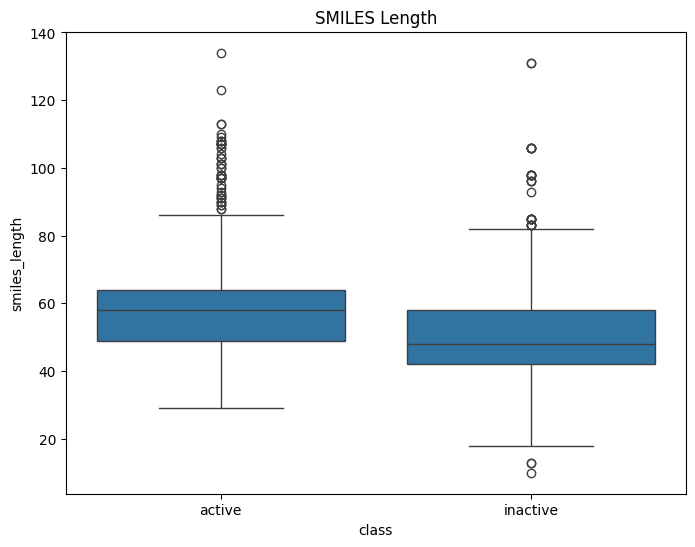

In [ ]:
df_final['smiles_length'] = df_final['canonical_smiles'].apply(len)
plt.figure(figsize=(8, 6))
sns.boxplot(x='class', y='smiles_length', data=df_final)
plt.title('SMILES Length')
plt.show()

In [ ]:
class LoaderData(nn.Module):
    def __init__(self, X, y, batch=32, test_size=0.2, seed=212, use_y=True):
        super().__init__()
        self.use_y = use_y
        if use_y:
            X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=seed)
            self.batch_size = batch
            self.X_train = X_train
            self.X_test = X_test
            self.y_train = y_train
            self.y_test = y_test

    def process_molecule(self, molecule, cls, use_y=True):
        return self.molecule_to_graph(molecule, cls, use_y)

    def forward(self, x=None):
        with concurrent.futures.ThreadPoolExecutor() as executor:
            if self.use_y:
              train_graphs = list(executor.map(self.process_molecule, self.X_train, self.y_train))
              val_graphs = list(executor.map(self.process_molecule, self.X_test, self.y_test))
            else:
              graphs = self.process_molecule(x, None, self.use_y)

        if self.use_y:
            train_loader = DL_geo(train_graphs, batch_size=self.batch_size, shuffle=True)
            val_loader = DL_geo(val_graphs, batch_size=self.batch_size, shuffle=False)
            return train_loader, val_loader
        else:
            return graphs

    def molecule_to_graph(self, molecule: str, y=None, use_y=True):
        mol = Chem.MolFromSmiles(molecule)
        if mol is None:
            return None

        atoms = [
            [
                atom.GetAtomicNum(),              # Nomor atom
                atom.GetMass(),                   # Massa atom
                int(atom.GetIsAromatic()),        # Apakah atom aromatik
                int(atom.GetHybridization()),     # Tipe hibridisasi
                atom.GetFormalCharge(),           # Muatan formal
                atom.GetDegree(),                 # Derajat atom
                atom.GetImplicitValence(),        # Valensi implisit
                atom.GetExplicitValence(),        # Valensi eksplisit
                int(atom.IsInRing()),             # Apakah dalam cincin
                int(atom.GetChiralTag()),         # Tag kiralitas
            ]
            for atom in mol.GetAtoms()
        ]

        edges = []
        edge_attr = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edges.append([i, j])
            edges.append([j, i])  # kedua arah untuk graf tak berarah

            bond_features = [
                bond.GetBondTypeAsDouble(),      # Tipe ikatan
                int(bond.GetIsConjugated()),     # Apakah ikatan terkonjugasi
                int(bond.GetIsAromatic()),       # Apakah ikatan aromatik
                int(bond.GetStereo()),           # Stereokimia ikatan
                int(bond.IsInRing()),            # Apakah ikatan dalam cincin
            ]
            edge_attr.append(bond_features)
            edge_attr.append(bond_features) # fitur edge untuk arah sebaliknya

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        x = torch.tensor(atoms, dtype=torch.float)

        if use_y:
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor([y], dtype=torch.long))
        else:
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        return data

class GNNBlock(nn.Module):
    def __init__(self, edge_features, c1, c2, dropout_rate=0.2, c1_=False):
        super().__init__()
        self.conv1 = GINEConv(nn.Linear(c1, c2), edge_dim=edge_features)
        self.conv2 = GINEConv(nn.Linear(c2, c1), edge_dim=edge_features)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, inputs, edge_index, edge_attr):
        x = self.dropout(F.leaky_relu(self.conv1(inputs, edge_index, edge_attr)))
        return self.conv2(x+inputs, edge_index, edge_attr)

class GNNModel(nn.Module):
    def __init__(self, num_features, edge_features, c1=128, c2=128, num_block=2):
        super().__init__()
        self.inputs = GINEConv(nn.Linear(num_features, c1//2), edge_dim=edge_features)
        self.conv = GINEConv(nn.Linear(c1//2, c1), edge_dim=edge_features)
        self.block = [GNNBlock(edge_features, c1, c2) for i in range(num_block)]
        self.cls = nn.Linear(c1, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.leaky_relu(self.inputs(x, edge_index, edge_attr))
        x = self.conv(x, edge_index, edge_attr)
        for block in self.block:
            x = block(x, edge_index, edge_attr)
        x = global_mean_pool(self.cls(x), data.batch)
        return x

class CreateModel(nn.Module):
    def __init__(self,
                 X, y,
                 epochs,
                 batch=32,
                 test_size=0.2,
                 seed=212,
                 c1=128,
                 c2=128,
                 num_block=2,
                 dropout_rate=0.3):
        super().__init__()
        print("Loading data ...")
        self.epochs = epochs
        self.X, self.y = X, y
        self.loader = LoaderData(X, y, batch, test_size, seed)
        self.train_loader, self.val_loader = self.loader()
        self.num_node_features = self.train_loader.dataset[0].x.size(1)
        self.num_edge_features = self.train_loader.dataset[0].edge_attr.size(1)
        self.model = GNNModel(self.num_node_features, self.num_edge_features, c1, c2, num_block)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = self.model.to(self.device)

    def forward(self, x):
        self.load= LoaderData(self.X, self.y, 1, 0.2, seed=212, use_y=False)
        data = self.load(x=x)
        out = self.model(data)
        return torch.sigmoid(out)

    def predict(self, x):
        return self.forward(x)

    def train(self, optimizer, criterion):
        self.model.train()
        total_loss = 0
        correct = 0
        with tqdm(self.train_loader, desc="Training", unit="batch") as t:
            for data in t:
                data = data.to(self.device)
                optimizer.zero_grad()
                out = self.model(data)
                loss = criterion(out.view(-1), data.y.float())
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pred = torch.sigmoid(out)
                pred = (pred > 0.5).float()
                correct += (pred.view(-1) == data.y).sum().item()
        avg_loss = total_loss / len(self.train_loader)
        accuracy = correct / len(self.train_loader.dataset)
        return avg_loss, accuracy

    def eval(self, threshold=0.5):
        self.model.eval()
        total_loss = 0
        correct = 0
        all_labels, all_preds = [], []
        with tqdm(self.val_loader, desc="Validation", unit="batch") as t:
            with torch.no_grad():
                for data in t:
                    data = data.to(self.device)
                    out = self.model(data)
                    pred = torch.sigmoid(out)
                    pred = (pred > threshold).float()
                    all_labels.extend(data.y.cpu().numpy())
                    all_preds.extend(pred.cpu().numpy())
        return all_labels, all_preds

    def validate(self, criterion):
        self.model.eval()
        total_loss = 0
        correct = 0
        with tqdm(self.val_loader, desc="Validation", unit="batch") as t:
            with torch.no_grad():
                for data in t:
                    data = data.to(self.device)
                    out = self.model(data)
                    loss = criterion(out.view(-1), data.y.float())
                    total_loss += loss.item()
                    pred = torch.sigmoid(out)
                    pred = (pred > 0.5).float()
                    correct += (pred.view(-1) == data.y).sum().item()
        avg_loss = total_loss / len(self.val_loader)
        accuracy = correct / len(self.val_loader.dataset)
        return avg_loss, accuracy

    def fit(self, optimizer, lr, loss, loss_w=None):
        optimizer, criterion = self.get_optim(optimizer, lr, loss, loss_w)
        t_acc, t_loss, v_acc, v_loss = [], [], [], []
        best_val_loss = float('inf')
        best_model_state_dict = None
        for epoch in range(1, self.epochs + 1):
            train_loss, train_acc = self.train(optimizer, criterion)
            val_loss, val_accuracy = self.validate(criterion)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state_dict = self.model.state_dict()
            print(f"Epoch {epoch}/{self.epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}\n")
            t_loss.append(train_loss)
            t_acc.append(train_acc)
            v_loss.append(val_loss)
            v_acc.append(val_accuracy)
        if best_model_state_dict:
            self.model.load_state_dict(best_model_state_dict)
            print("Restored model to the best state based on validation loss.")
        history = {"Train Loss":t_loss, "Train Acc":t_acc, "Val Loss":v_loss, "Val Acc":v_acc}
        return history

    def get_optim(self, optimizer, lr, loss, loss_w):
        optimizer = optimizer(self.model.parameters(), lr=lr)
        if loss_w is not None:
            try:
              criterion = loss(weight=loss_w)
            except:
              criterion = loss(pos_weight=loss_w)
        else:
            criterion = loss()
        return optimizer, criterion

In [ ]:
X = df_final['canonical_smiles']
y = df_final['class'].map({'active': 1, 'inactive': 0})
EPOCHS = 100
model = CreateModel(X, y, epochs=EPOCHS, batch=32, test_size=0.2, seed=212)

Loading data ...


In [ ]:
loss_weights = torch.tensor([0.7])
history = model.fit(torch.optim.Adam, lr=0.001, loss=nn.BCEWithLogitsLoss, loss_w=loss_weights)

Validation: 100%|██████████| 29/29 [00:01<00:00, 18.39batch/s]


Epoch 1/100 | Train Loss: 1.1941 | Train Acc: 0.5219 | Val Loss: 0.6389 | Val Acc: 0.5144



Validation: 100%|██████████| 29/29 [00:00<00:00, 30.20batch/s]


Epoch 2/100 | Train Loss: 0.6107 | Train Acc: 0.5211 | Val Loss: 0.5496 | Val Acc: 0.5122



Validation: 100%|██████████| 29/29 [00:00<00:00, 46.47batch/s]


Epoch 3/100 | Train Loss: 0.5654 | Train Acc: 0.5325 | Val Loss: 0.6391 | Val Acc: 0.5611



Validation: 100%|██████████| 29/29 [00:00<00:00, 71.06batch/s]


Epoch 4/100 | Train Loss: 0.5315 | Train Acc: 0.5372 | Val Loss: 0.5015 | Val Acc: 0.5711



Validation: 100%|██████████| 29/29 [00:00<00:00, 72.37batch/s]


Epoch 5/100 | Train Loss: 0.5119 | Train Acc: 0.5447 | Val Loss: 0.4854 | Val Acc: 0.5900



Validation: 100%|██████████| 29/29 [00:00<00:00, 54.16batch/s]


Epoch 6/100 | Train Loss: 0.5153 | Train Acc: 0.5483 | Val Loss: 0.4753 | Val Acc: 0.5578



Validation: 100%|██████████| 29/29 [00:00<00:00, 75.56batch/s]


Epoch 7/100 | Train Loss: 0.4873 | Train Acc: 0.5769 | Val Loss: 0.4734 | Val Acc: 0.6044



Validation: 100%|██████████| 29/29 [00:00<00:00, 71.61batch/s]


Epoch 8/100 | Train Loss: 0.4831 | Train Acc: 0.5725 | Val Loss: 0.4702 | Val Acc: 0.6022



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.93batch/s]


Epoch 9/100 | Train Loss: 0.4826 | Train Acc: 0.5775 | Val Loss: 0.4745 | Val Acc: 0.5644



Validation: 100%|██████████| 29/29 [00:00<00:00, 66.60batch/s]


Epoch 10/100 | Train Loss: 0.4800 | Train Acc: 0.5894 | Val Loss: 0.4490 | Val Acc: 0.6489



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.60batch/s]


Epoch 11/100 | Train Loss: 0.4953 | Train Acc: 0.5636 | Val Loss: 0.4791 | Val Acc: 0.5167



Validation: 100%|██████████| 29/29 [00:00<00:00, 66.36batch/s]


Epoch 12/100 | Train Loss: 0.4673 | Train Acc: 0.6047 | Val Loss: 0.4635 | Val Acc: 0.6022



Validation: 100%|██████████| 29/29 [00:00<00:00, 50.70batch/s]


Epoch 13/100 | Train Loss: 0.4618 | Train Acc: 0.6064 | Val Loss: 0.4569 | Val Acc: 0.6267



Validation: 100%|██████████| 29/29 [00:00<00:00, 72.93batch/s]


Epoch 14/100 | Train Loss: 0.4777 | Train Acc: 0.5822 | Val Loss: 0.4410 | Val Acc: 0.6656



Validation: 100%|██████████| 29/29 [00:00<00:00, 71.87batch/s]


Epoch 15/100 | Train Loss: 0.4653 | Train Acc: 0.6083 | Val Loss: 0.4349 | Val Acc: 0.6600



Validation: 100%|██████████| 29/29 [00:00<00:00, 49.68batch/s]


Epoch 16/100 | Train Loss: 0.4540 | Train Acc: 0.6275 | Val Loss: 0.4560 | Val Acc: 0.6178



Validation: 100%|██████████| 29/29 [00:00<00:00, 65.61batch/s]


Epoch 17/100 | Train Loss: 0.4529 | Train Acc: 0.6228 | Val Loss: 0.4989 | Val Acc: 0.5189



Validation: 100%|██████████| 29/29 [00:00<00:00, 71.22batch/s]


Epoch 18/100 | Train Loss: 0.4645 | Train Acc: 0.6106 | Val Loss: 0.4374 | Val Acc: 0.6633



Validation: 100%|██████████| 29/29 [00:00<00:00, 48.52batch/s]


Epoch 19/100 | Train Loss: 0.4518 | Train Acc: 0.6289 | Val Loss: 0.4473 | Val Acc: 0.6400



Validation: 100%|██████████| 29/29 [00:00<00:00, 66.50batch/s]


Epoch 20/100 | Train Loss: 0.4598 | Train Acc: 0.6183 | Val Loss: 0.4276 | Val Acc: 0.6856



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.41batch/s]


Epoch 21/100 | Train Loss: 0.4520 | Train Acc: 0.6319 | Val Loss: 0.4321 | Val Acc: 0.6633



Validation: 100%|██████████| 29/29 [00:00<00:00, 73.65batch/s]


Epoch 22/100 | Train Loss: 0.4582 | Train Acc: 0.6214 | Val Loss: 0.4263 | Val Acc: 0.6756



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.22batch/s]


Epoch 23/100 | Train Loss: 0.4368 | Train Acc: 0.6381 | Val Loss: 0.4260 | Val Acc: 0.6578



Validation: 100%|██████████| 29/29 [00:00<00:00, 71.31batch/s]


Epoch 24/100 | Train Loss: 0.4620 | Train Acc: 0.6194 | Val Loss: 0.4227 | Val Acc: 0.6700



Validation: 100%|██████████| 29/29 [00:00<00:00, 74.13batch/s]


Epoch 25/100 | Train Loss: 0.4450 | Train Acc: 0.6358 | Val Loss: 0.4207 | Val Acc: 0.6778



Validation: 100%|██████████| 29/29 [00:00<00:00, 62.49batch/s]


Epoch 26/100 | Train Loss: 0.4410 | Train Acc: 0.6447 | Val Loss: 0.4227 | Val Acc: 0.6889



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.20batch/s]


Epoch 27/100 | Train Loss: 0.4556 | Train Acc: 0.6267 | Val Loss: 0.4241 | Val Acc: 0.6667



Validation: 100%|██████████| 29/29 [00:00<00:00, 69.28batch/s]


Epoch 28/100 | Train Loss: 0.4363 | Train Acc: 0.6522 | Val Loss: 0.4217 | Val Acc: 0.6600



Validation: 100%|██████████| 29/29 [00:00<00:00, 51.55batch/s]


Epoch 29/100 | Train Loss: 0.4388 | Train Acc: 0.6461 | Val Loss: 0.4245 | Val Acc: 0.6567



Validation: 100%|██████████| 29/29 [00:00<00:00, 73.75batch/s]


Epoch 30/100 | Train Loss: 0.4325 | Train Acc: 0.6517 | Val Loss: 0.4290 | Val Acc: 0.6578



Validation: 100%|██████████| 29/29 [00:00<00:00, 75.11batch/s]


Epoch 31/100 | Train Loss: 0.4421 | Train Acc: 0.6369 | Val Loss: 0.4328 | Val Acc: 0.6478



Validation: 100%|██████████| 29/29 [00:00<00:00, 53.73batch/s]


Epoch 32/100 | Train Loss: 0.4366 | Train Acc: 0.6461 | Val Loss: 0.4150 | Val Acc: 0.6733



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.56batch/s]


Epoch 33/100 | Train Loss: 0.4283 | Train Acc: 0.6639 | Val Loss: 0.4184 | Val Acc: 0.6800



Validation: 100%|██████████| 29/29 [00:00<00:00, 72.06batch/s]


Epoch 34/100 | Train Loss: 0.4202 | Train Acc: 0.6694 | Val Loss: 0.4043 | Val Acc: 0.6789



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.29batch/s]


Epoch 35/100 | Train Loss: 0.4222 | Train Acc: 0.6664 | Val Loss: 0.5864 | Val Acc: 0.4900



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.77batch/s]


Epoch 36/100 | Train Loss: 0.4225 | Train Acc: 0.6750 | Val Loss: 0.4103 | Val Acc: 0.6756



Validation: 100%|██████████| 29/29 [00:00<00:00, 72.00batch/s]


Epoch 37/100 | Train Loss: 0.4240 | Train Acc: 0.6617 | Val Loss: 0.4032 | Val Acc: 0.6778



Validation: 100%|██████████| 29/29 [00:00<00:00, 52.14batch/s]


Epoch 38/100 | Train Loss: 0.4219 | Train Acc: 0.6683 | Val Loss: 0.4215 | Val Acc: 0.6700



Validation: 100%|██████████| 29/29 [00:00<00:00, 49.75batch/s]


Epoch 39/100 | Train Loss: 0.4238 | Train Acc: 0.6606 | Val Loss: 0.4091 | Val Acc: 0.6678



Validation: 100%|██████████| 29/29 [00:00<00:00, 71.66batch/s]


Epoch 40/100 | Train Loss: 0.4199 | Train Acc: 0.6697 | Val Loss: 0.4034 | Val Acc: 0.6744



Validation: 100%|██████████| 29/29 [00:00<00:00, 73.41batch/s]


Epoch 41/100 | Train Loss: 0.4191 | Train Acc: 0.6697 | Val Loss: 0.4381 | Val Acc: 0.6189



Validation: 100%|██████████| 29/29 [00:00<00:00, 52.31batch/s]


Epoch 42/100 | Train Loss: 0.4262 | Train Acc: 0.6664 | Val Loss: 0.4122 | Val Acc: 0.6700



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.51batch/s]


Epoch 43/100 | Train Loss: 0.4176 | Train Acc: 0.6617 | Val Loss: 0.4119 | Val Acc: 0.6722



Validation: 100%|██████████| 29/29 [00:00<00:00, 73.37batch/s]


Epoch 44/100 | Train Loss: 0.4248 | Train Acc: 0.6581 | Val Loss: 0.4069 | Val Acc: 0.6844



Validation: 100%|██████████| 29/29 [00:00<00:00, 53.81batch/s]


Epoch 45/100 | Train Loss: 0.4136 | Train Acc: 0.6828 | Val Loss: 0.4283 | Val Acc: 0.6556



Validation: 100%|██████████| 29/29 [00:00<00:00, 71.97batch/s]


Epoch 46/100 | Train Loss: 0.4173 | Train Acc: 0.6739 | Val Loss: 0.4129 | Val Acc: 0.6800



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.32batch/s]


Epoch 47/100 | Train Loss: 0.4127 | Train Acc: 0.6800 | Val Loss: 0.4033 | Val Acc: 0.7033



Validation: 100%|██████████| 29/29 [00:00<00:00, 75.87batch/s]


Epoch 48/100 | Train Loss: 0.4073 | Train Acc: 0.6911 | Val Loss: 0.3977 | Val Acc: 0.6944



Validation: 100%|██████████| 29/29 [00:00<00:00, 74.06batch/s]


Epoch 49/100 | Train Loss: 0.4087 | Train Acc: 0.6831 | Val Loss: 0.3990 | Val Acc: 0.6911



Validation: 100%|██████████| 29/29 [00:00<00:00, 74.07batch/s]


Epoch 50/100 | Train Loss: 0.4056 | Train Acc: 0.6825 | Val Loss: 0.3974 | Val Acc: 0.7033



Validation: 100%|██████████| 29/29 [00:00<00:00, 69.83batch/s]


Epoch 51/100 | Train Loss: 0.4172 | Train Acc: 0.6814 | Val Loss: 0.4447 | Val Acc: 0.6489



Validation: 100%|██████████| 29/29 [00:00<00:00, 50.38batch/s]


Epoch 52/100 | Train Loss: 0.4163 | Train Acc: 0.6792 | Val Loss: 0.4152 | Val Acc: 0.6867



Validation: 100%|██████████| 29/29 [00:00<00:00, 72.37batch/s]


Epoch 53/100 | Train Loss: 0.4035 | Train Acc: 0.6942 | Val Loss: 0.4094 | Val Acc: 0.6956



Validation: 100%|██████████| 29/29 [00:00<00:00, 74.47batch/s]


Epoch 54/100 | Train Loss: 0.4029 | Train Acc: 0.6939 | Val Loss: 0.4054 | Val Acc: 0.6933



Validation: 100%|██████████| 29/29 [00:00<00:00, 49.90batch/s]


Epoch 55/100 | Train Loss: 0.3994 | Train Acc: 0.7036 | Val Loss: 0.4120 | Val Acc: 0.6844



Validation: 100%|██████████| 29/29 [00:00<00:00, 74.68batch/s]


Epoch 56/100 | Train Loss: 0.4008 | Train Acc: 0.6950 | Val Loss: 0.3961 | Val Acc: 0.7067



Validation: 100%|██████████| 29/29 [00:00<00:00, 72.21batch/s]


Epoch 57/100 | Train Loss: 0.4015 | Train Acc: 0.6967 | Val Loss: 0.3828 | Val Acc: 0.7167



Validation: 100%|██████████| 29/29 [00:00<00:00, 51.71batch/s]


Epoch 58/100 | Train Loss: 0.3946 | Train Acc: 0.7067 | Val Loss: 0.3817 | Val Acc: 0.7267



Validation: 100%|██████████| 29/29 [00:00<00:00, 72.72batch/s]


Epoch 59/100 | Train Loss: 0.3970 | Train Acc: 0.6981 | Val Loss: 0.4228 | Val Acc: 0.6778



Validation: 100%|██████████| 29/29 [00:00<00:00, 74.40batch/s]


Epoch 60/100 | Train Loss: 0.4098 | Train Acc: 0.6761 | Val Loss: 0.4037 | Val Acc: 0.6822



Validation: 100%|██████████| 29/29 [00:00<00:00, 71.54batch/s]


Epoch 61/100 | Train Loss: 0.3948 | Train Acc: 0.7036 | Val Loss: 0.3792 | Val Acc: 0.7133



Validation: 100%|██████████| 29/29 [00:00<00:00, 73.16batch/s]


Epoch 62/100 | Train Loss: 0.3846 | Train Acc: 0.7167 | Val Loss: 0.3868 | Val Acc: 0.7078



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.13batch/s]


Epoch 63/100 | Train Loss: 0.3855 | Train Acc: 0.7175 | Val Loss: 0.3855 | Val Acc: 0.7478



Validation: 100%|██████████| 29/29 [00:00<00:00, 68.80batch/s]


Epoch 64/100 | Train Loss: 0.3821 | Train Acc: 0.7189 | Val Loss: 0.3861 | Val Acc: 0.7100



Validation: 100%|██████████| 29/29 [00:00<00:00, 50.59batch/s]


Epoch 65/100 | Train Loss: 0.3865 | Train Acc: 0.7172 | Val Loss: 0.3690 | Val Acc: 0.7422



Validation: 100%|██████████| 29/29 [00:00<00:00, 73.93batch/s]


Epoch 66/100 | Train Loss: 0.3732 | Train Acc: 0.7292 | Val Loss: 0.3734 | Val Acc: 0.7367



Validation: 100%|██████████| 29/29 [00:00<00:00, 69.70batch/s]


Epoch 67/100 | Train Loss: 0.3684 | Train Acc: 0.7347 | Val Loss: 0.3982 | Val Acc: 0.7078



Validation: 100%|██████████| 29/29 [00:00<00:00, 47.41batch/s]


Epoch 68/100 | Train Loss: 0.3754 | Train Acc: 0.7278 | Val Loss: 0.3910 | Val Acc: 0.7078



Validation: 100%|██████████| 29/29 [00:00<00:00, 69.40batch/s]


Epoch 69/100 | Train Loss: 0.3723 | Train Acc: 0.7269 | Val Loss: 0.3699 | Val Acc: 0.7433



Validation: 100%|██████████| 29/29 [00:00<00:00, 71.02batch/s]


Epoch 70/100 | Train Loss: 0.3674 | Train Acc: 0.7422 | Val Loss: 0.3650 | Val Acc: 0.7456



Validation: 100%|██████████| 29/29 [00:00<00:00, 47.99batch/s]


Epoch 71/100 | Train Loss: 0.3659 | Train Acc: 0.7403 | Val Loss: 0.3651 | Val Acc: 0.7544



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.57batch/s]


Epoch 72/100 | Train Loss: 0.3605 | Train Acc: 0.7478 | Val Loss: 0.3830 | Val Acc: 0.7267



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.78batch/s]


Epoch 73/100 | Train Loss: 0.3714 | Train Acc: 0.7347 | Val Loss: 0.3742 | Val Acc: 0.7378



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.04batch/s]


Epoch 74/100 | Train Loss: 0.3643 | Train Acc: 0.7397 | Val Loss: 0.3685 | Val Acc: 0.7389



Validation: 100%|██████████| 29/29 [00:00<00:00, 66.73batch/s]


Epoch 75/100 | Train Loss: 0.3566 | Train Acc: 0.7503 | Val Loss: 0.3560 | Val Acc: 0.7644



Validation: 100%|██████████| 29/29 [00:00<00:00, 64.16batch/s]


Epoch 76/100 | Train Loss: 0.3566 | Train Acc: 0.7436 | Val Loss: 0.3669 | Val Acc: 0.7411



Validation: 100%|██████████| 29/29 [00:00<00:00, 66.32batch/s]


Epoch 77/100 | Train Loss: 0.3454 | Train Acc: 0.7606 | Val Loss: 0.4090 | Val Acc: 0.7133



Validation: 100%|██████████| 29/29 [00:00<00:00, 47.90batch/s]


Epoch 78/100 | Train Loss: 0.3541 | Train Acc: 0.7478 | Val Loss: 0.3440 | Val Acc: 0.7500



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.74batch/s]


Epoch 79/100 | Train Loss: 0.3434 | Train Acc: 0.7678 | Val Loss: 0.3823 | Val Acc: 0.7222



Validation: 100%|██████████| 29/29 [00:00<00:00, 67.76batch/s]


Epoch 80/100 | Train Loss: 0.3552 | Train Acc: 0.7503 | Val Loss: 0.3602 | Val Acc: 0.7456



Validation: 100%|██████████| 29/29 [00:00<00:00, 51.21batch/s]


Epoch 81/100 | Train Loss: 0.3491 | Train Acc: 0.7553 | Val Loss: 0.3610 | Val Acc: 0.7433



Validation: 100%|██████████| 29/29 [00:00<00:00, 66.33batch/s]


Epoch 82/100 | Train Loss: 0.3386 | Train Acc: 0.7675 | Val Loss: 0.3588 | Val Acc: 0.7400



Validation: 100%|██████████| 29/29 [00:00<00:00, 48.79batch/s]


Epoch 83/100 | Train Loss: 0.3424 | Train Acc: 0.7658 | Val Loss: 0.3395 | Val Acc: 0.7600



Validation: 100%|██████████| 29/29 [00:00<00:00, 48.73batch/s]


Epoch 84/100 | Train Loss: 0.3560 | Train Acc: 0.7436 | Val Loss: 0.3513 | Val Acc: 0.7533



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.35batch/s]


Epoch 85/100 | Train Loss: 0.3353 | Train Acc: 0.7617 | Val Loss: 0.3444 | Val Acc: 0.7711



Validation: 100%|██████████| 29/29 [00:00<00:00, 73.36batch/s]


Epoch 86/100 | Train Loss: 0.3348 | Train Acc: 0.7706 | Val Loss: 0.3387 | Val Acc: 0.7656



Validation: 100%|██████████| 29/29 [00:00<00:00, 52.14batch/s]


Epoch 87/100 | Train Loss: 0.3312 | Train Acc: 0.7756 | Val Loss: 0.3262 | Val Acc: 0.7744



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.05batch/s]


Epoch 88/100 | Train Loss: 0.3267 | Train Acc: 0.7858 | Val Loss: 0.3299 | Val Acc: 0.7711



Validation: 100%|██████████| 29/29 [00:00<00:00, 71.78batch/s]


Epoch 89/100 | Train Loss: 0.3341 | Train Acc: 0.7664 | Val Loss: 0.3522 | Val Acc: 0.7444



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.14batch/s]


Epoch 90/100 | Train Loss: 0.3278 | Train Acc: 0.7775 | Val Loss: 0.3247 | Val Acc: 0.7789



Validation: 100%|██████████| 29/29 [00:00<00:00, 50.90batch/s]


Epoch 91/100 | Train Loss: 0.3364 | Train Acc: 0.7717 | Val Loss: 0.3464 | Val Acc: 0.7644



Validation: 100%|██████████| 29/29 [00:00<00:00, 73.49batch/s]


Epoch 92/100 | Train Loss: 0.3246 | Train Acc: 0.7747 | Val Loss: 0.3384 | Val Acc: 0.7478



Validation: 100%|██████████| 29/29 [00:00<00:00, 71.45batch/s]


Epoch 93/100 | Train Loss: 0.3259 | Train Acc: 0.7811 | Val Loss: 0.3249 | Val Acc: 0.7833



Validation: 100%|██████████| 29/29 [00:00<00:00, 47.00batch/s]


Epoch 94/100 | Train Loss: 0.3205 | Train Acc: 0.7936 | Val Loss: 0.3417 | Val Acc: 0.7567



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.74batch/s]


Epoch 95/100 | Train Loss: 0.3184 | Train Acc: 0.7772 | Val Loss: 0.3327 | Val Acc: 0.7733



Validation: 100%|██████████| 29/29 [00:00<00:00, 70.69batch/s]


Epoch 96/100 | Train Loss: 0.3269 | Train Acc: 0.7750 | Val Loss: 0.3605 | Val Acc: 0.7389



Validation: 100%|██████████| 29/29 [00:00<00:00, 51.10batch/s]


Epoch 97/100 | Train Loss: 0.3111 | Train Acc: 0.7878 | Val Loss: 0.3435 | Val Acc: 0.7489



Validation: 100%|██████████| 29/29 [00:00<00:00, 71.88batch/s]


Epoch 98/100 | Train Loss: 0.3255 | Train Acc: 0.7881 | Val Loss: 0.3214 | Val Acc: 0.7889



Validation: 100%|██████████| 29/29 [00:00<00:00, 72.68batch/s]


Epoch 99/100 | Train Loss: 0.3155 | Train Acc: 0.7928 | Val Loss: 0.3445 | Val Acc: 0.7556



Validation: 100%|██████████| 29/29 [00:00<00:00, 53.37batch/s]

Epoch 100/100 | Train Loss: 0.3166 | Train Acc: 0.7822 | Val Loss: 0.3132 | Val Acc: 0.7933

Restored model to the best state based on validation loss.


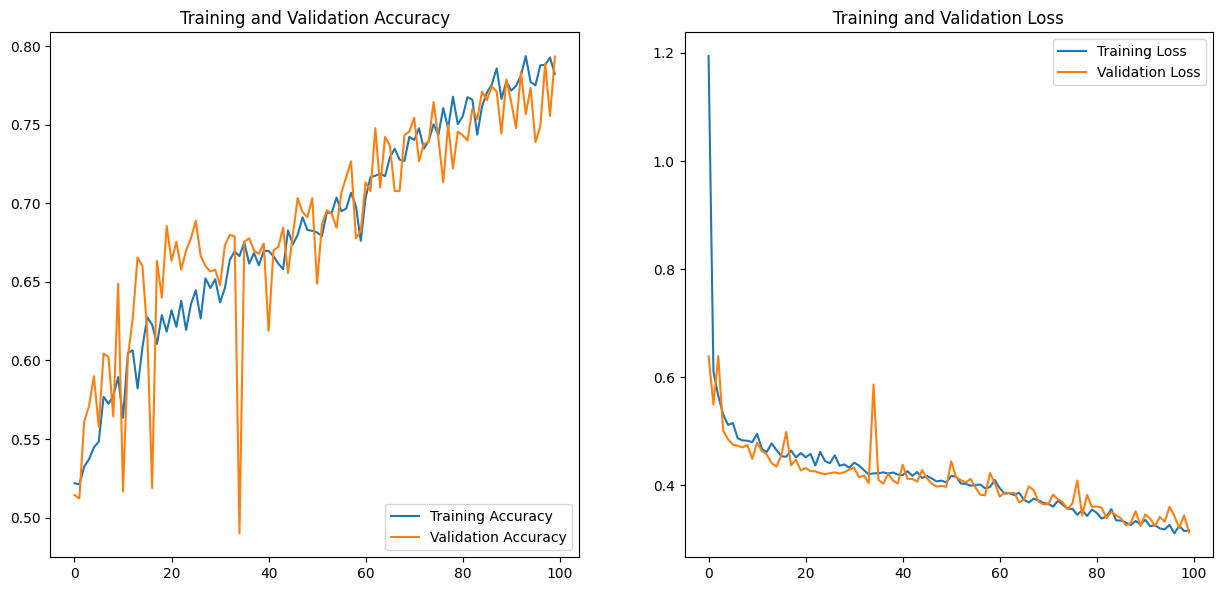

In [ ]:
epochs_range = range(EPOCHS)
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, history['Train Acc'], label='Training Accuracy')
plt.plot(epochs_range, history['Val Acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, history['Train Loss'], label='Training Loss')
plt.plot(epochs_range, history['Val Loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

def tune_threshold(threshold):
    best_f1, best_thres = 0, 0
    y_t, y_p = 0, 0
    for i in threshold:
        y_true, y_pred = model.eval(threshold=i)
        f1 = f1_score(y_true, y_pred, average='macro')
        if best_f1 < f1:
            best_f1, best_thres = f1, i
            y_t = y_true
            y_p = y_pred
    return best_thres, y_t, y_p

threshold, y_true, y_pred = tune_threshold(np.arange(0.1, 0.95, 0.05))

Validation: 100%|██████████| 29/29 [00:00<00:00, 73.66batch/s]


Precision: 0.81
Recall: 0.80
F1 Score: 0.80
Akurasi: 0.81
Threshold: 0.55


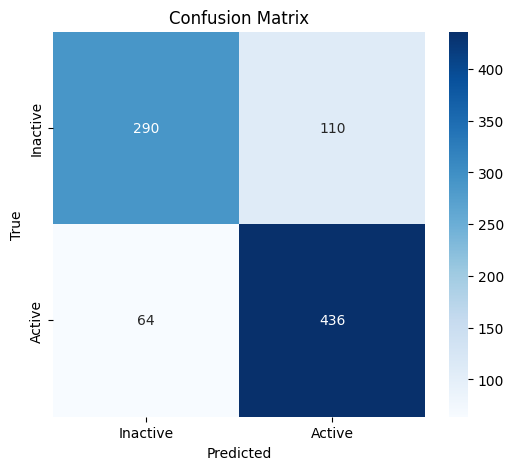

In [ ]:
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Akurasi: {accuracy:.2f}")
print(f"Threshold: {threshold:.2f}")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Inactive', 'Active'], yticklabels=['Inactive', 'Active'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
def predict(model, molekul, threshold):
    prob = model.predict(molekul)
    pred = "active" if prob[0] > threshold else "inactive"
    return pred

print(predict(model, "Oc1cccc(-c2nc(N3CCOCC3)c3sccc3n2)c1", threshold))
print(predict(model, "CCn1c(=O)c2ccnn2c2cc(NC)c(C(=O)NCc3cccnc3)cc21", threshold))

active
inactive
